In [1]:
import tensorflow as tf
from keras.layers import Input, Dense, Reshape, Flatten, AveragePooling2D, Add, Layer
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import UpSampling2D, Conv2D
from keras.models import Sequential, Model, save_model, load_model
from keras.optimizers import Adam
import matplotlib.pyplot as plt
import numpy as np
import os
import librosa
import librosa.display
from librosa.output import write_wav
from tqdm import tqdm
from skimage.transform import resize
from keras.initializers import RandomNormal
from keras.constraints import max_norm
from keras import backend
import IPython.display as ipd

Using TensorFlow backend.


In [2]:
tf.logging.set_verbosity(tf.logging.ERROR)

In [3]:
command = 'go'
img_shape = (128, 32, 1) # rows, columns, channels
latent_dim = 100
power = .5
sr = 16000
model_sizes = [(16, 4, 1), (32, 8, 1), (64, 16, 1), (128, 32, 1)]
batch_size = 32
n_epochs = 30
g_lr = .0001
d_lr = .0002

In [4]:
X_train = np.load('./data/' + command + '-train.npy')
_max = np.amax(X_train)

# normalize
X_train = X_train / _max

In [5]:
def wasserstein_loss(y_true, y_pred):
    return backend.mean(y_true * y_pred)

In [6]:
def scale_dataset(images, new_shape):
    images_list = list()
    for image in images:
        # resize with nearest neighbor interpolation
        new_image = resize(image, new_shape, 0)
        images_list.append(new_image)
    return np.asarray(images_list)

In [7]:
class WeightedSum(Add):
    # init with default value
    def __init__(self, alpha=0.0, **kwargs):
        super(WeightedSum, self).__init__(**kwargs)
        self.alpha = backend.variable(alpha, name='ws_alpha')

    # output a weighted sum of inputs
    def _merge_function(self, inputs):
        # only supports a weighted sum of two inputs
        assert (len(inputs) == 2)
        output = ((1.0 - self.alpha) * inputs[0]) + (self.alpha * inputs[1])
        return output

In [8]:
# pixel-wise feature vector normalization layer
class PixelNormalization(Layer):
    # initialize the layer
    def __init__(self, **kwargs):
        super(PixelNormalization, self).__init__(**kwargs)

    # perform the operation
    def call(self, inputs):
        # calculate square pixel values
        values = inputs**2.0
        # calculate the mean pixel values
        mean_values = backend.mean(values, axis=-1, keepdims=True)
        # ensure the mean is not zero
        mean_values += 1.0e-8
        # calculate the sqrt of the mean squared value (L2 norm)
        l2 = backend.sqrt(mean_values)
        # normalize values by the l2 norm
        normalized = inputs / l2
        return normalized

    # define the output shape of the layer
    def compute_output_shape(self, input_shape):
        return input_shape

In [9]:
def define_discriminator():
    # initialize weights
    init = RandomNormal(stddev=0.02)
    # set a weight constraint
    const = max_norm(1.0)
    model_list = []
    
    in_image = Input(shape=model_sizes[0])

    d = Conv2D(128, (1,1), padding='same', kernel_initializer=init, kernel_constraint=const)(in_image)
    d = LeakyReLU(alpha=0.2)(d)
    
    d = Conv2D(128, (3,3), padding='same', kernel_initializer=init, kernel_constraint=const)(d)
    d = LeakyReLU(alpha=0.2)(d)
    
    d = Conv2D(128, (4,4), padding='same', kernel_initializer=init, kernel_constraint=const)(d)
    d = LeakyReLU(alpha=0.2)(d)
    
    d = Flatten()(d)
    out_class = Dense(1)(d)
    
    model = Model(in_image, out_class)
    model.compile(loss=wasserstein_loss, optimizer=Adam(lr=d_lr, beta_1=0, beta_2=0.99, epsilon=10e-8))
    model_list.append([model, model])
    
    # create submodels
    for i in range(1, len(model_sizes)):
        # get prior model without the fade-on
        old_model = model_list[i - 1][0]
        
        # create new model for next resolution
        models = add_discriminator_block(old_model, i)
        model_list.append(models)
    return model_list

In [10]:
def add_discriminator_block(old_model, i, n_input_layers=3):
    init = RandomNormal(stddev=0.02)
    const = max_norm(1.0)
    # get shape of existing model
    in_shape = list(old_model.input.shape)
    
    # define new input shape
    input_shape = model_sizes[i]
    
    in_image = Input(shape=input_shape)
   
    d = Conv2D(128, (1,1), padding='same', kernel_initializer=init, kernel_constraint=const)(in_image)
    d = LeakyReLU(alpha=0.2)(d)
    
    d = Conv2D(128, (3,3), padding='same', kernel_initializer=init, kernel_constraint=const)(d)
    d = LeakyReLU(alpha=0.2)(d)
    
    d = Conv2D(128, (3,3), padding='same', kernel_initializer=init, kernel_constraint=const)(d)
    d = LeakyReLU(alpha=0.2)(d)
    
    d = AveragePooling2D()(d)
    block_new = d
    
    # skip the input, 1x1 and activation for the old model
    for i in range(n_input_layers, len(old_model.layers)):
        d = old_model.layers[i](d)
    # define straight-through model
    model1 = Model(in_image, d)
    model1.compile(loss=wasserstein_loss, optimizer=Adam(lr=d_lr, beta_1=0, beta_2=0.99, epsilon=10e-8))
    
    # downsample the new larger image
    downsample = AveragePooling2D()(in_image)
    
    # connect old input processing to downsampled new input
    block_old = old_model.layers[1](downsample)
    block_old = old_model.layers[2](block_old)
    
    # fade in output of old model input layer with new input
    d = WeightedSum()([block_old, block_new])
    
    # skip the input, 1x1 and activation for the old model
    for i in range(n_input_layers, len(old_model.layers)):
        d = old_model.layers[i](d)
    # define straight-through model
    model2 = Model(in_image, d)
    model2.compile(loss=wasserstein_loss, optimizer=Adam(lr=d_lr, beta_1=0, beta_2=0.99, epsilon=10e-8))
    return [model1, model2]

In [11]:
def define_generator():
    init = RandomNormal(stddev=0.02)
    const = max_norm(1.0)
    model_list = []
    
    in_latent = Input(shape=(latent_dim,))
    g  = Dense(128 * model_sizes[0][0] * model_sizes[0][1], kernel_initializer=init, kernel_constraint=const)(in_latent)
    g = Reshape((model_sizes[0][0], model_sizes[0][1], 128))(g)
    
    g = Conv2D(128, (3,3), padding='same', kernel_initializer=init, kernel_constraint=const)(g)
    g = PixelNormalization()(g)
    g = LeakyReLU(alpha=0.2)(g)
    
    g = Conv2D(128, (3,3), padding='same', kernel_initializer=init, kernel_constraint=const)(g)
    g = PixelNormalization()(g)
    g = LeakyReLU(alpha=0.2)(g)
    
    out_image = Conv2D(1, (1,1), padding='same', kernel_initializer=init, kernel_constraint=const, activation='sigmoid')(g)
    
    model = Model(in_latent, out_image)
    model_list.append([model, model])
    
    # create submodels
    for i in range(1, len(model_sizes)):
        # get prior model without the fade-on
        old_model = model_list[i - 1][0]
        # create new model for next resolution
        models = add_generator_block(old_model)
        model_list.append(models)
    return model_list

In [12]:
def add_generator_block(old_model):
    init = RandomNormal(stddev=0.02)
    const = max_norm(1.0)
    
    # get the end of the last block
    block_end = old_model.layers[-2].output
    
    # upsample, and define new block
    upsampling = UpSampling2D()(block_end)
    g = Conv2D(128, (3,3), padding='same', kernel_initializer=init, kernel_constraint=const)(upsampling)
    g = PixelNormalization()(g)
    g = LeakyReLU(alpha=0.2)(g)
    
    g = Conv2D(128, (3,3), padding='same', kernel_initializer=init, kernel_constraint=const)(g)
    g = PixelNormalization()(g)
    g = LeakyReLU(alpha=0.2)(g)
    
    out_image = Conv2D(1, (1,1), padding='same', kernel_initializer=init, kernel_constraint=const, activation='sigmoid')(g)
    
    model1 = Model(old_model.input, out_image)
    
    # get the output layer from old model
    out_old = old_model.layers[-1]
    # connect the upsampling to the old output layer
    out_image2 = out_old(upsampling)
    # define new output image as the weighted sum of the old and new models
    merged = WeightedSum()([out_image2, out_image])
    
    model2 = Model(old_model.input, merged)
    return [model1, model2]

In [13]:
def define_composite(discriminators, generators):
    model_list = []
    
    for i in range(len(discriminators)):
        g_models, d_models = generators[i], discriminators[i]
        
        # straight-through model
        d_models[0].trainable = False
        model1 = Sequential()
        model1.add(g_models[0])
        model1.add(d_models[0])
        model1.compile(loss=wasserstein_loss, optimizer=Adam(lr=g_lr, beta_1=0, beta_2=0.99, epsilon=10e-8))
        
        # fade-in model
        d_models[1].trainable = False
        model2 = Sequential()
        model2.add(g_models[1])
        model2.add(d_models[1])
        model2.compile(loss=wasserstein_loss, optimizer=Adam(lr=g_lr, beta_1=0, beta_2=0.99, epsilon=10e-8))
        
        model_list.append([model1, model2])
    return model_list

In [14]:
def generate_real_samples(dataset, n_samples):
    i = np.random.randint(0, dataset.shape[0], n_samples)
    X = dataset[i]
    y = np.ones((n_samples, 1))
    return X, y

In [15]:
def generate_fake_samples(generator, n_samples):
    noise = np.random.normal(0, 1, (n_samples, latent_dim))
    generated_image = generator.predict(noise)
    y = -np.ones((n_samples, 1))
    return generated_image, y

In [16]:
def update_fadein(models, step, n_steps):
    # calculate current alpha (linear from 0 to 1)
    alpha = step / float(n_steps - 1)
    # update the alpha for each model
    for model in models:
        for layer in model.layers:
            if isinstance(layer, WeightedSum):
                backend.set_value(layer.alpha, alpha)

In [17]:
def train(g_models, d_models, gan_models, dataset, latent_dim):
    # fit the baseline model
    g_normal, d_normal, gan_normal = g_models[0][0], d_models[0][0], gan_models[0][0]
    
    # scale dataset to appropriate size
    gen_shape = g_normal.output_shape
    scaled_data = scale_dataset(dataset, gen_shape[1:])
    print('Data Size:', scaled_data.shape)
    
    # train normal or straight-through models
    train_epochs(g_normal, d_normal, gan_normal, scaled_data)
    save_images('tuned', gen_shape, g_normal)
    
    for i in range(1, len(g_models)):
        # retrieve models for this level of growth
        [g_normal, g_fadein] = g_models[i]
        [d_normal, d_fadein] = d_models[i]
        [gan_normal, gan_fadein] = gan_models[i]
        # scale dataset to appropriate size
        gen_shape = g_normal.output_shape
        scaled_data = scale_dataset(dataset, gen_shape[1:])
        print('Data Size:', scaled_data.shape)
        # train fade-in models for next level of growth
        train_epochs(g_fadein, d_fadein, gan_fadein, scaled_data, True)
        save_images('faded', gen_shape, g_fadein)
        # train normal or straight-through models
        train_epochs(g_normal, d_normal, gan_normal, scaled_data)
        save_images('tuned', gen_shape, g_normal)

In [18]:
def train_epochs(g_model, d_model, gan_model, dataset, fadein=False):
    # calculate the number of training iterations
    n_steps = int(dataset.shape[0] / batch_size) * n_epochs
    
    for i in range(n_steps):
        # update alpha for all WeightedSum layers when fading in new blocks
        if fadein:
            update_fadein([g_model, d_model, gan_model], i, n_steps)
        
        X_real, y_real = generate_real_samples(dataset, batch_size)
        X_fake, y_fake = generate_fake_samples(g_model, batch_size)
        
        # update discriminator model
        d_loss_real = d_model.train_on_batch(X_real, y_real)
        d_loss_fake = d_model.train_on_batch(X_fake, y_fake)
        
        # update the generator via the discriminator's error
        z_input = np.random.normal(0, 1, (batch_size, latent_dim))
        y_real2 = np.ones((batch_size, 1))
        g_loss = gan_model.train_on_batch(z_input, y_real2)
        
    print('dreal=%.2f, dfake=%.2f, g=%.2f' % (d_loss_real, d_loss_fake, g_loss))

In [19]:
def save_audio(model, epoch):
    noise = np.random.normal(0, 1, (1, latent_dim))
    generated_images = model.predict(noise)
    generated_image = np.squeeze(generated_images[0])
    audio = librosa.feature.inverse.mel_to_audio(denormalize(generated_image), sr=sr, power=power)
    write_wav('audio/' + command + '_' + str(epoch) + '.wav', sr=sr, y=audio)

In [20]:
def save_images(status, gen_shape, generator):
    rows, cols = 2, 2
    noise = np.random.normal(0, 1, (rows * cols, latent_dim))
    gen_imgs = generator.predict(noise)

    fig, axs = plt.subplots(rows, cols)
    cnt = 1
    for i in range(rows * cols):
        plt.subplot(rows, cols, cnt)
        librosa.display.specshow(gen_imgs[i, :,:,0])
        cnt += 1
    name = 'images/%02dx%02d-%s' % (gen_shape[1], gen_shape[2], status)
    fig.savefig(name)
    plt.close()

In [21]:
def save(gan, generator, discriminator):
    discriminator.trainable = False
    save_model(gan, './saved_models/gan')
    discriminator.trainable = True
    save_model(generator, './saved_models/generator')
    save_model(discriminator, './saved_models/discriminator')

def load():
    discriminator = load_model('./saved_models/discriminator')
    generator = load_model('./saved_models/generator')
    gan = load_model('./saved_models/gan')
    gan.summary()
    discriminator.summary()
    generator.summary()

    return gan, generator, discriminator

In [22]:
def denormalize(array):
    return (array * _max) 

In [23]:
d_models = define_discriminator()
g_models = define_generator()
gan_models = define_composite(d_models, g_models)

In [24]:
train(g_models, d_models, gan_models, X_train, latent_dim,)

Data Size: (1701, 16, 4, 1)


c:\users\user\anaconda3\envs\tf_gpu\lib\site-packages\keras\engine\training.py:493: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'
c:\users\user\anaconda3\envs\tf_gpu\lib\site-packages\keras\engine\training.py:493: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'
c:\users\user\anaconda3\envs\tf_gpu\lib\site-packages\keras\engine\training.py:493: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


dreal=0.06, dfake=-0.04, g=0.06
Data Size: (1701, 32, 8, 1)


c:\users\user\anaconda3\envs\tf_gpu\lib\site-packages\keras\engine\training.py:493: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'
c:\users\user\anaconda3\envs\tf_gpu\lib\site-packages\keras\engine\training.py:493: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


dreal=0.01, dfake=-0.00, g=0.01


c:\users\user\anaconda3\envs\tf_gpu\lib\site-packages\keras\engine\training.py:493: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'
c:\users\user\anaconda3\envs\tf_gpu\lib\site-packages\keras\engine\training.py:493: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


dreal=0.00, dfake=0.00, g=0.00
Data Size: (1701, 64, 16, 1)


c:\users\user\anaconda3\envs\tf_gpu\lib\site-packages\keras\engine\training.py:493: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'
c:\users\user\anaconda3\envs\tf_gpu\lib\site-packages\keras\engine\training.py:493: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


dreal=-0.00, dfake=0.00, g=-0.00


c:\users\user\anaconda3\envs\tf_gpu\lib\site-packages\keras\engine\training.py:493: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'
c:\users\user\anaconda3\envs\tf_gpu\lib\site-packages\keras\engine\training.py:493: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


dreal=0.00, dfake=0.00, g=0.00
Data Size: (1701, 128, 32, 1)


c:\users\user\anaconda3\envs\tf_gpu\lib\site-packages\keras\engine\training.py:493: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'
c:\users\user\anaconda3\envs\tf_gpu\lib\site-packages\keras\engine\training.py:493: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


dreal=-0.56, dfake=0.44, g=-0.14


c:\users\user\anaconda3\envs\tf_gpu\lib\site-packages\keras\engine\training.py:493: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'
c:\users\user\anaconda3\envs\tf_gpu\lib\site-packages\keras\engine\training.py:493: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


dreal=-12757.22, dfake=8047.08, g=-2701.48


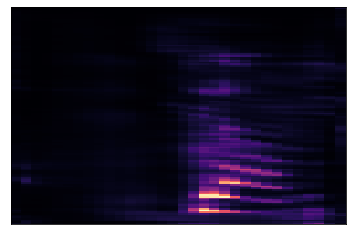

In [28]:
noise = np.random.normal(0, 1, (1, latent_dim))
generated_image = g_models[3][0].predict(noise)
generated_image = np.squeeze(generated_image)
librosa.display.specshow(generated_image)

test = librosa.feature.inverse.mel_to_audio(denormalize(generated_image), sr=sr, power=power)
#write_wav('test.wav', sr=sr, y=test)
ipd.Audio(test, rate=sr)

In [29]:
def train_final_model(g_model, d_model, gan_model, epochs, progress_interval, save_interval):
    scaled_data = scale_dataset(X_train, (128, 32, 1))
    for epoch in range(epochs):
        X_real, y_real = generate_real_samples(scaled_data, batch_size)
        X_fake, y_fake = generate_fake_samples(g_model, batch_size)
        
        # update discriminator model
        d_loss_real = d_model.train_on_batch(X_real, y_real)
        d_loss_fake = d_model.train_on_batch(X_fake, y_fake)
        acc = 0.5 * np.add(d_loss_real, d_loss_fake)
        
        # update the generator via the discriminator's error
        z_input = np.random.normal(0, 1, (batch_size, latent_dim))
        y_real2 = np.ones((batch_size, 1))
        g_loss = gan_model.train_on_batch(z_input, y_real2)
        
        if epoch % progress_interval == 0:
            print(str(epoch) + ' dreal=%.5f, dfake=%.5f, g=%.5f' % (d_loss_real, d_loss_fake, g_loss))

        if epoch % save_interval == 0:
            save_images('final' + str(epoch), (16, 128, 32), g_model)
            save_audio(g_model, epoch)
                   
    return g_model, d_model, gan_model

In [30]:
generator = g_models[3][0]
discriminator = d_models[3][0]
gan = gan_models[3][0]

In [ ]:
generator, discriminator, gan = train_final_model(generator, discriminator, gan, 151, 50, 50)

0 dreal=-64463696.00000, dfake=30895168.00000, g=-24252368.00000


In [ ]:
noise = np.random.normal(0, 1, (1, latent_dim))
generated_image = generator.predict(noise)
generated_image = np.squeeze(generated_image)
librosa.display.specshow(generated_image)

test = librosa.feature.inverse.mel_to_audio(denormalize(generated_image), sr=sr, power=power)
#write_wav('test.wav', sr=sr, y=test)
ipd.Audio(test, rate=sr)

In [111]:
def generate_audio(n, generator):
    noise = np.random.normal(0, 1, (n, latent_dim))
    generated_images = generator.predict(noise)
    
    for i in tqdm(range(n)):
        generated_image = np.squeeze(generated_images[i])
        img = librosa.feature.inverse.mel_to_audio(generated_image, sr=sr, power=power)
        write_wav('./data/speech_clips/generated/' + command + '_' + str(i) + '.wav', sr=sr, y=img)

In [112]:
generate_audio(500, generator)

100%|████████████████████████████████████████████████████████████████████████████████| 500/500 [01:09<00:00,  7.20it/s]
